# Final Project
### DNSC 6290
### Weike Zhou, Joy Yin, Seungheon Han, Zach Vila

### 1. Check the given data sets

In [0]:
%fs ls 'dbfs:/mnt/course-datasets/project-data'

path,name,size
dbfs:/mnt/course-datasets/project-data/ad_info.txt,ad_info.txt,5350670676
dbfs:/mnt/course-datasets/project-data/category.txt,category.txt,752
dbfs:/mnt/course-datasets/project-data/combined_stream.txt,combined_stream.txt,15614549295
dbfs:/mnt/course-datasets/project-data/location.txt,location.txt,58976
dbfs:/mnt/course-datasets/project-data/search_click.txt,search_click.txt,11023566785
dbfs:/mnt/course-datasets/project-data/search_info.txt,search_info.txt,9469373867
dbfs:/mnt/course-datasets/project-data/user_info.txt,user_info.txt,104614699


## 2. Load tables

### load text data files:
##### * "ad_info" 
##### * "search_click"
##### * "search_info"
##### * "location"

In [0]:
ad = spark.read.text("dbfs:/mnt/course-datasets/project-data/ad_info.txt")
srch_clck = spark.read.text("dbfs:/mnt/course-datasets/project-data/search_click.txt")
srch_info = spark.read.text("dbfs:/mnt/course-datasets/project-data/search_info.txt")
location = spark.read.text("dbfs:/mnt/course-datasets/project-data/location.txt")

In [0]:
display(ad.take(4))

value
AdID LocationID CategoryID Params Price Title IsContext
"1 343 43 {1283:'С пробегом', 633:'Синий', 1159:0, 210:'Toyota', 184:'0 - 4 999', 1162:0, 1165:0, 1135:0, 1329:'2.0', 1138:0, 277:'Estima', 695:'Полный', 696:'правый', 697:'Не битый', 186:'Дизель', 187:'Микроавтобус', 188:'1993', 185:'Механика'} 160000 Toyota Estima, 1993 0"
"2 992 34 {817:'Кузов', 5:'Запчасти', 598:'Для автомобилей'} 750 Передние брызговики Форд Фокус 2 родные 0"
3 3771 53 {181:'Промышленное'} 18000 Дровокол 0


In [0]:
display(srch_clck.take(4))

value
SearchID AdID Position ObjectType HistCTR IsClick
2 11441863 1 3 0.001804 0
2 22968355 7 3 0.004723 0
3 212187 7 3 0.029701 0


In [0]:
display(srch_info.take(4))

value
SearchID SearchDate IPID UserID IsUserLoggedOn SearchQuery LocationID CategoryID SearchParams
1 2015-05-18 19:54:32.0 1717090 3640266 0 1729 5
2 2015-05-12 14:21:28.0 1731568 769304 0 697 50
3 2015-05-12 07:09:42.0 793143 640089 0 1261 12


In [0]:
display(location.take(4))

value
LocationID Level RegionID CityID
7 3 83 2386
23 3 28 3224
26 3 41 1316


## 3 Convert the tab delimited tables into a tidy dataframe

In [0]:
from pyspark.sql.functions import split, col, explode
from pyspark.sql.functions import monotonically_increasing_id

### 3.1 dataframe for "ad_info"

In [0]:
## extract the first row from the table, which should be the header of the dataframe 

# register the view
ad.createOrReplaceTempView("ad_view")

# get the first row that goes for the header of the dataframe
ad_hdr = spark.sql('select * from ad_view limit 1') \
    .withColumn("value", split(col("value"), "\t"))

In [0]:
# check the number of candidate columns
ad_hdr.select(explode("value")).count()

Out[4]: 7

In [0]:
# add the header along with the corresponding columns
ad_df = ad.withColumn("value", split(col("value"),"\t")) \
    .withColumn("idx", monotonically_increasing_id()) \
    .withColumn(ad_hdr.select(col("value").getItem(0)).collect()[0][0], col("value").getItem(0)) \
    .withColumn(ad_hdr.select(col("value").getItem(1)).collect()[0][0], col("value").getItem(1)) \
    .withColumn(ad_hdr.select(col("value").getItem(2)).collect()[0][0], col("value").getItem(2)) \
    .withColumn(ad_hdr.select(col("value").getItem(3)).collect()[0][0], col("value").getItem(3)) \
    .withColumn(ad_hdr.select(col("value").getItem(4)).collect()[0][0], col("value").getItem(4)) \
    .withColumn(ad_hdr.select(col("value").getItem(5)).collect()[0][0], col("value").getItem(5)) \
    .withColumn(ad_hdr.select(col("value").getItem(6)).collect()[0][0], col("value").getItem(6)) \
    .filter(col("idx") > 0) \
    . drop("value").cache()

In [0]:
# display top 4 of the converted dataframe
display(ad_df.limit(4))

idx,AdID,LocationID,CategoryID,Params,Price,Title,IsContext
1,1,343,43,"{1283:'С пробегом', 633:'Синий', 1159:0, 210:'Toyota', 184:'0 - 4 999', 1162:0, 1165:0, 1135:0, 1329:'2.0', 1138:0, 277:'Estima', 695:'Полный', 696:'правый', 697:'Не битый', 186:'Дизель', 187:'Микроавтобус', 188:'1993', 185:'Механика'}",160000,"Toyota Estima, 1993",0
2,2,992,34,"{817:'Кузов', 5:'Запчасти', 598:'Для автомобилей'}",750,Передние брызговики Форд Фокус 2 родные,0
3,3,3771,53,{181:'Промышленное'},18000,Дровокол,0
4,4,4294,57,{130:'Приборы и аксессуары'},1500,Продам ходули складные,0


### 3.2 dataframe for "search_click"

In [0]:
srch_clck_hdr = srch_clck.withColumn("idx", monotonically_increasing_id()) \
    .filter(col("idx") == 0) \
    .select("value") \
    .withColumn("value", split(col("value"), "\t"))

In [0]:
# check the number of candidate columns
srch_clck_hdr.select(explode("value")).count()

Out[8]: 6

In [0]:
# add the header along with the corresponding columns
srch_clck_df = srch_clck.withColumn("value", split(col("value"),"\t")) \
    .withColumn("idx", monotonically_increasing_id()) \
    .withColumn(srch_clck_hdr.select(col("value").getItem(0)).collect()[0][0], col("value").getItem(0)) \
    .withColumn(srch_clck_hdr.select(col("value").getItem(1)).collect()[0][0], col("value").getItem(1)) \
    .withColumn(srch_clck_hdr.select(col("value").getItem(2)).collect()[0][0], col("value").getItem(2)) \
    .withColumn(srch_clck_hdr.select(col("value").getItem(3)).collect()[0][0], col("value").getItem(3)) \
    .withColumn(srch_clck_hdr.select(col("value").getItem(4)).collect()[0][0], col("value").getItem(4)) \
    .withColumn(srch_clck_hdr.select(col("value").getItem(5)).collect()[0][0], col("value").getItem(5)) \
    .filter(col("idx") > 0) \
    .drop("value") \
    .drop("idx").cache()

In [0]:
# display top 4 of the converted dataframe
display(srch_clck_df.limit(4))

SearchID,AdID,Position,ObjectType,HistCTR,IsClick
2,11441863,1,3,0.001804,0
2,22968355,7,3,0.004723,0
3,212187,7,3,0.029701,0
3,34084553,1,3,0.004300,0


### 3.3 dataframe for "srch_info"

In [0]:
## extract the first row from the table, which should be the header of the dataframe 

# register the view
srch_info.createOrReplaceTempView("srch_info")

# get the first row that goes for the header of the dataframe
srch_info_hdr = spark.sql('select * from srch_info limit 1') \
    .withColumn("value", split(col("value"), "\t"))

In [0]:
# check the number of candidate columns
srch_info_hdr.select(explode("value")).count()

Out[14]: 9

In [0]:
# add the header along with the corresponding columns
srch_info_df = srch_info.withColumn("value", split(col("value"),"\t")) \
    .withColumn("idx", monotonically_increasing_id()) \
    .withColumn(srch_info_hdr.select(col("value").getItem(0)).collect()[0][0], col("value").getItem(0)) \
    .withColumn(srch_info_hdr.select(col("value").getItem(1)).collect()[0][0], col("value").getItem(1)) \
    .withColumn(srch_info_hdr.select(col("value").getItem(2)).collect()[0][0], col("value").getItem(2)) \
    .withColumn(srch_info_hdr.select(col("value").getItem(3)).collect()[0][0], col("value").getItem(3)) \
    .withColumn(srch_info_hdr.select(col("value").getItem(4)).collect()[0][0], col("value").getItem(4)) \
    .withColumn(srch_info_hdr.select(col("value").getItem(5)).collect()[0][0], col("value").getItem(5)) \
    .withColumn(srch_info_hdr.select(col("value").getItem(6)).collect()[0][0], col("value").getItem(6)) \
    .withColumn(srch_info_hdr.select(col("value").getItem(7)).collect()[0][0], col("value").getItem(7)) \
    .withColumn(srch_info_hdr.select(col("value").getItem(8)).collect()[0][0], col("value").getItem(8)) \
    .filter(col("idx") > 0) \
    .drop("value") \
    .drop("idx").cache()

In [0]:
display(srch_info_df.limit(4))

SearchID,SearchDate,IPID,UserID,IsUserLoggedOn,SearchQuery,LocationID,CategoryID,SearchParams
1,2015-05-18 19:54:32.0,1717090,3640266,0,,1729,5,
2,2015-05-12 14:21:28.0,1731568,769304,0,,697,50,
3,2015-05-12 07:09:42.0,793143,640089,0,,1261,12,
4,2015-05-10 18:11:01.0,898705,3573776,0,,3960,22,"{83:'Обувь', 175:'Женская одежда', 88:'38'}"


### 3.4 dataframe for "location"

In [0]:
# get the first row that goes for the header of the dataframe
location_hdr = location.withColumn("idx", monotonically_increasing_id()) \
    .filter(col("idx") == 0) \
    .select("value") \
    .withColumn("value", split(col("value"), "\t"))

In [0]:
# check the number of candidate columns
location_hdr.select(explode("value")).count()

Out[19]: 4

In [0]:
# add the header along with the corresponding columns
location_df = location.withColumn("value", split(col("value"),"\t")) \
    .withColumn("idx", monotonically_increasing_id()) \
    .withColumn(location_hdr.select(col("value").getItem(0)).collect()[0][0], col("value").getItem(0)) \
    .withColumn(location_hdr.select(col("value").getItem(1)).collect()[0][0], col("value").getItem(1)) \
    .withColumn(location_hdr.select(col("value").getItem(2)).collect()[0][0], col("value").getItem(2)) \
    .withColumn(location_hdr.select(col("value").getItem(3)).collect()[0][0], col("value").getItem(3)) \
    .filter(col("idx") > 0) \
    .drop("value") \
    .drop("idx").cache()

In [0]:
display(location_df.limit(4))

LocationID,Level,RegionID,CityID
7,3,83,2386
23,3,28,3224
26,3,41,1316
30,3,63,2565


## 4. Merge dataframes

### 4.1 Merge "ad_df" & "srch_clck_df"

In [0]:
# Rename the column "AdID" to "ID"
# This is for distinguishing the columns with the same name in ad_df & srch_clck after merging the two dataframes 
ad_df_new = ad_df.withColumnRenamed("AdID", "ID")

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-4219049453637862> in <module> 
 1 # Rename the column "AdID" to "ID" 
 2 # This is for distinguishing the columns with the same name in ad_df & srch_clck after merging the two dataframes 
 ----> 3 ad_df_new = ad_df . withColumnRenamed ( "AdID" , "ID" ) 

 NameError : name 'ad_df' is not defined

In [0]:
# Convert string type to integer type
ad_df = ad_df_new.withColumn("Price", ad_df_new.Price.cast('int'))
srch_clck_df = srch_clck_df.withColumn("IsClick", srch_clck_df.IsClick.cast('int'))

In [0]:
# register the view
ad_df.createOrReplaceTempView("ad_df")
srch_clck_df.createOrReplaceTempView("srch_clck_df")

# inner join "ad_df" to "srch_clck" on "AdID" attribute 
# including only the contextual ads rows 
ad_srch_df = spark.sql("""SELECT * 
                      FROM srch_clck_df sc
                      INNER JOIN ad_df ad
                      ON sc.AdID = ad.ID
                      WHERE ad.IsContext == 1
                      """).cache()

In [0]:
display(ad_srch_df.limit(5))

SearchID,AdID,Position,ObjectType,HistCTR,IsClick,idx,ID,LocationID,CategoryID,Params,Price,Title,IsContext
10791783,10018714,1,3,0.000010,0,85900057759,10018714,,34,"{5:'Шины, диски и колёса', 709:'Диски'}",4390,Литой диск Alcasta M26 8x18/5x114.3 ET35 D60.1,1
20430515,10018714,1,3,0.000010,0,85900057759,10018714,,34,"{5:'Шины, диски и колёса', 709:'Диски'}",4390,Литой диск Alcasta M26 8x18/5x114.3 ET35 D60.1,1
30111611,10018714,1,3,0.000010,0,85900057759,10018714,,34,"{5:'Шины, диски и колёса', 709:'Диски'}",4390,Литой диск Alcasta M26 8x18/5x114.3 ET35 D60.1,1
38774869,10018714,7,3,0.000169,0,85900057759,10018714,,34,"{5:'Шины, диски и колёса', 709:'Диски'}",4390,Литой диск Alcasta M26 8x18/5x114.3 ET35 D60.1,1
39013095,10018714,1,3,0.000010,0,85900057759,10018714,,34,"{5:'Шины, диски и колёса', 709:'Диски'}",4390,Литой диск Alcasta M26 8x18/5x114.3 ET35 D60.1,1


### 4.2 Merge "srch_info_df" & "srch_clck_df" & "location_df"

In [0]:
# register the view

srch_info_df.createOrReplaceTempView("srch_info_df")
location_df.createOrReplaceTempView("location_df")
srch_clck_df.createOrReplaceTempView("srch_clck_df")

In [0]:
###join three tables which are location dataset, search info dataset and search click dataset.
combine_srch_df = spark.sql("select location_df.LocationID, srch_info_df.SearchID, IsClick from srch_info_df inner join Location_df on location_df.LocationID=srch_info_df.LocationID inner join srch_clck_df on srch_info_df.SearchID=srch_clck_df.SearchID ")

In [0]:
display(combine_srch_df.limit(5))

LocationID,SearchID,IsClick
1261,100000046,0
1261,100000046,null
1261,100000046,0
2840,100000095,0
2840,100000095,null


### store all the merged dataframes into FileStore

In [0]:
#ad_df.write.parquet("dbfs:/FileStore/ad_df")
#srch_clck_df.write.parquet("dbfs:/FileStore/srch_clck_df")
#srch_info_df.write.parquet("dbfs:/FileStore/srch_info_df")
#location_df.write.parquet("dbfs:/FileStore/location_df")

#ad_srch_df.write.parquet("dbfs:/FileStore/ad_srch_df")
#combine_srch_df.write.parquet("dbfs:/FileStore/combine_srch_df")

## 5. Questions & Answers

In [0]:
#initialize dependencies, packages for visual exploration of data

import matplotlib.pyplot as plt  # basic plotting
from matplotlib.lines import Line2D  # necessary for custom legends
import seaborn as sns  # slightly better plotting
import numpy as np  # for basic array manipulation
import pandas as pd  # for dataframe manipulation
%matplotlib inline

### 5.1 Which contextual advertisements were clicked by the users the most?
#### - Top 10 Ads on which the users clicked the most

In [0]:
# register the view
ad_srch_df.createOrReplaceTempView("ad_srch_df")
ad_df.createOrReplaceTempView("ad_df")

# manipulate the ad_df & srch_clck & ad_srch_df
click_rank = spark.sql("""SELECT AdID, Title, num_of_click, avg_CTR, Price
                       FROM (SELECT AdID, SUM(IsClick) AS num_of_click, ROUND(AVG(HistCTR), 4) AS avg_CTR
                       FROM ad_srch_df 
                       GROUP BY AdID
                       ORDER BY num_of_click
                       DESC) sub
                       INNER JOIN ad_df
                       ON sub.AdID = ad_df.ID
                       ORDER BY num_of_click
                       DESC
                       """)

In [0]:
display(click_rank.limit(5))

In [0]:
# convert the spark dataframe to pandas dataframe
click_rank_pd = click_rank.select("*").toPandas()

In [0]:
click_rank_pd.head(5)

In [0]:
# check the data types
click_rank_pd.info()

In [0]:
label = list(click_rank_pd.loc[0:9, "Title"])
label.reverse()
index = np.arange(len(label))
click_rank_bars = click_rank_pd.loc[0:9,"num_of_click"].sort_values(ascending = True)

In [0]:
# Horizontal Bar Chart
plt.barh(index, click_rank_bars)
plt.title('Top10 Ads', fontsize=18)
plt.ylabel('Title', fontsize=15)
plt.xlabel('# of Clicks', fontsize=15)
plt.yticks(index, label, fontsize=13, rotation=0)
plt.show()

##### Results:
##### * The bar chart shows the top 10 ads with their titles that were clicked by users the most

### 5.2 Do the click records have certain relationships with the ad prices?

In [0]:
#correlation analysis
y_name = 'Price'
x_names = ['num_of_click', 'avg_CTR']

corr = click_rank_pd[x_names + [y_name]].corr()
_ = sns.heatmap(corr,
                xticklabels=corr.columns.values,
                yticklabels=corr.columns.values, annot = True)

In [0]:
# scatter plot
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
fig.suptitle('Relationships of Click with Price', size = 18)

sns.regplot(y = click_rank_pd['Price'],
            x = click_rank_pd['num_of_click'],
           fit_reg=False, ax=axes[0]).set_title('Price vs. num_of_click')


sns.regplot(y = click_rank_pd['Price'],
            x = click_rank_pd['avg_CTR'],
           fit_reg=False, ax=axes[1]).set_title('Price vs. avg_CTR')

##### Results:
##### * the correlation between Price and num_of_click is very small (= -0.0009)
##### * the correlation between Price and avg_CTR is very small (= -0.005)
##### * the corresponding scatter plot show that there are no linear relationships among the three variables

### 5.3 Which features are most correlated with the chosen response variable (Is_Click)?

In [0]:
#convert spark dataframe to pandas dataframe for ease of analysis
pandas_df = srch_clck_df.select("*").toPandas()

In [0]:
#view created pandas dataframe
pandas_df.head(5)

In [0]:
#explore variable types
pandas_df.info()

In [0]:
#convert the datatypes
pandas_df['SearchID'] =  pandas_df['SearchID'].astype('int')
pandas_df['AdID'] =  pandas_df['AdID'].astype('int')
pandas_df['Position'] =  pandas_df['Position'].astype('int')
pandas_df['ObjectType'] =  pandas_df['ObjectType'].astype('int')
pandas_df['IsClick'] =  pandas_df['IsClick'].astype('bool')

#remove index column
pandas_df.drop(['idx'], axis=1, inplace=True)
pandas_df.head(5)

In [0]:
#data exploration with boxplot
sns.boxplot(data=pandas_df['Position'])
plt.show()

In [0]:
#correlation analysis
plt.figure(figsize=(16, 6))

# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(pandas_df.corr(), dtype=np.bool))
heatmap = sns.heatmap(pandas_df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='coolwarm')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

In [0]:
#data exploration of IsClick with histogram
sns.distplot(pandas_df['IsClick'])

In [0]:
#summarize dataset
print('pandas_df = %d, columns = %d' % (pandas_df.shape[0], pandas_df.shape[1]))
pandas_df.describe(percentiles=[.1, .25, .5, .75, .9], include='all')

### 5.4
### What is the distribution of unique advertisements?
### What Position is most utilized for ads on a webpage?

In [0]:
#convert spark dataframe to pandas dataframe for ease of analysis
pandas_df2 = ad_df.select("*").toPandas()

In [0]:
#remove index column
pandas_df2.drop(['idx'], axis=1, inplace=True)

#view created pandas dataframe
pandas_df2.head(5)

In [0]:
#explore variable types
pandas_df2.info()

#convert the datatypes
pandas_df2['AdID'] =  pandas_df2['AdID'].astype('int')
pandas_df2['IsContext'] =  pandas_df2['IsContext'].astype('bool')

In [0]:
#data exploration with boxplot
sns.boxplot(data=pandas_df2['AdID'])
plt.show()

In [0]:
#data exploration of AdID with group by
totals = pandas_df2['Price'].groupby(pandas_df2['AdID']).sum()
print(totals)

In [0]:
#summarize dataset
print('pandas_df2 = %d, columns = %d' % (pandas_df2.shape[0], pandas_df2.shape[1]))
pandas_df2.describe(percentiles=[.1, .25, .5, .75, .9], include='all')

### 5.5 What are the most Searched Ids and what are the locations of them?

In [0]:
###display the joined table
combine_srch_df.createOrReplaceTempView("combine_srch_df")
display(combine_srch_df.limit(10))

LocationID,SearchID,IsClick
1261,100000046,0
1261,100000046,null
1261,100000046,0
2840,100000095,0
2840,100000095,null
1261,100000104,0
1261,100000104,0
346,100000169,0
346,100000169,null
346,100000169,null


In [0]:
###rank the searchID by counting the number of its appearance to show IDs that searched most
search_rank = spark.sql("select combine_srch_df.SearchID, LocationID, count(combine_srch_df.SearchID) from combine_srch_df group by combine_srch_df.SearchID,LocationID order by count(combine_srch_df.SearchID) desc limit 10")

In [0]:
search_rank_10 = search_rank.take(10)

In [0]:
###here are the top 10 locations of those IDs that searched most.
display(search_rank_10)

In [0]:
search_rank_10 = search_rank.select("*").toPandas()
search_rank_10.head(5)

Out[19]:

,SearchID,LocationID,count(SearchID)
0,10271616,2875,10
1,82455946,1937,10
2,28795322,760,9
3,60783325,1261,8
4,2016953,2513,8


In [0]:
search_rank_10.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 # Column Non-Null Count Dtype 
--- ------ -------------- ----- 
 0 SearchID 10 non-null object
 1 LocationID 10 non-null object
 2 count(SearchID) 10 non-null int64 
dtypes: int64(1), object(2)
memory usage: 368.0+ bytes

In [0]:
search_rank_10['count(SearchID)'] =  search_rank_10['count(SearchID)'].astype('int')

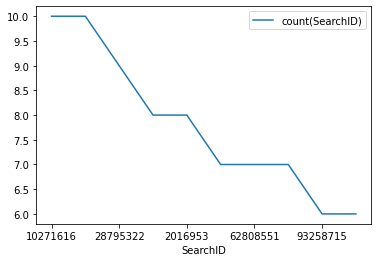

In [0]:
###data exploration with line
search_rank_10.plot(kind='line',x="SearchID", y="count(SearchID)")
plt.show()

Out[23]:

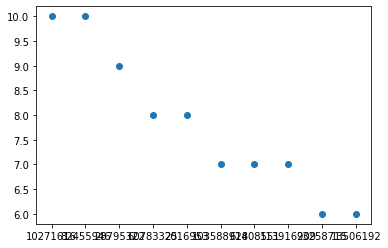

<matplotlib.collections.PathCollection at 0x7fc580765100>

In [0]:
plt.scatter(search_rank_10['SearchID'].values, search_rank_10['count(SearchID)'])